# Explaining Logistic Sentiment Analysis Model with SHAP (SHapley Additive exPlanations)

## 1. Import libraries

In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer

## 2. Read Dataset
The dataset (FinancialPhraseBank) contains the sentiments for financial news headlines from the perspective of a retail investor.  
Available on Kaggle: https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news/data

In [2]:
df = pd.read_csv('data/all-data.csv', encoding='latin_1', header=None, names=["label", "text"])
df.head(10)

,label,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
5,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
6,positive,"For the last quarter of 2010 , Componenta 's n..."
7,positive,"In the third quarter of 2010 , net sales incre..."
8,positive,Operating profit rose to EUR 13.1 mn from EUR ...
9,positive,"Operating profit totalled EUR 21.1 mn , up fro..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   4846 non-null   object
 1   text    4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


## 3. Data Cleansing

### 3.1 Duplicate Values Detection

In [4]:
df.duplicated().sum()

6

In [5]:
# Drop duplicates
df.drop_duplicates(inplace=True)

### 3.2 Missing values Detection

In [6]:
df.isnull().values.any()

False

### 3.2 Text Preprocessing

In [7]:
def clean_text(text):
    # Step 1: Convert text to lowercase
    text = text.lower()
    # Step 2: Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Step 3: Tokenization (split text into words)
    tokens = word_tokenize(text)
    # Step 4: Remove stopwords
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Step 5: Join tokens back into cleaned text
    cleaned_text = " ".join(filtered_tokens)
    
    return cleaned_text

In [8]:
df["clean_text"]= df["text"].apply(clean_text)
df.head(10)

,label,text,clean_text
0,neutral,"According to Gran , the company has no plans t...",according gran company plans move production r...
1,neutral,Technopolis plans to develop in stages an area...,technopolis plans develop stages area less squ...
2,negative,The international electronic industry company ...,international electronic industry company elco...
3,positive,With the new production plant the company woul...,new production plant company would increase ca...
4,positive,According to the company 's updated strategy f...,according company updated strategy years baswa...
5,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...,financing aspocomp growth aspocomp aggressivel...
6,positive,"For the last quarter of 2010 , Componenta 's n...",last quarter componenta net sales doubled eurm...
7,positive,"In the third quarter of 2010 , net sales incre...",third quarter net sales increased eur mn opera...
8,positive,Operating profit rose to EUR 13.1 mn from EUR ...,operating profit rose eur mn eur mn correspond...
9,positive,"Operating profit totalled EUR 21.1 mn , up fro...",operating profit totalled eur mn eur mn repres...


## 4. Data Exploration

### 4.1 Sentiment Distribution

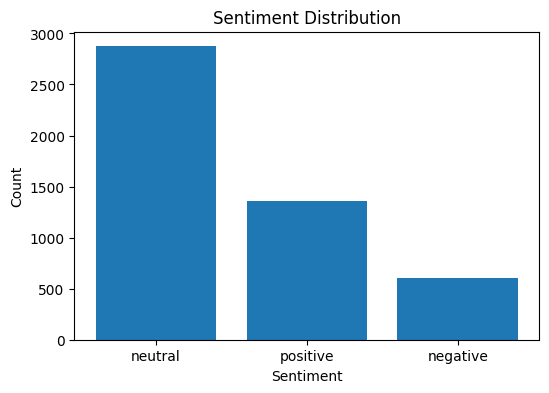

In [9]:
sentiment_counts = df['label'].value_counts()
plt.figure(figsize=(6, 4))
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')
plt.show()

### 4.2 Text Length Distribution by Labels (Sentiment)

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


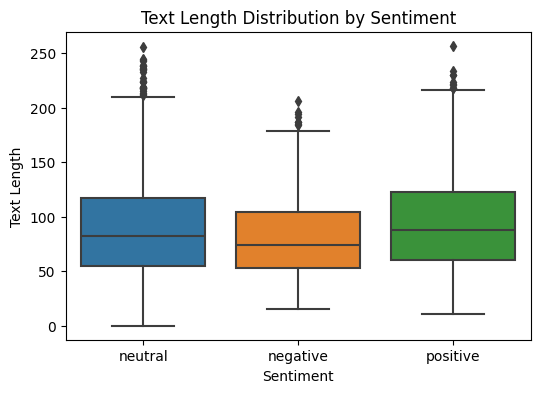

In [10]:
# Calculate text length for each sample
df['text_length'] = df['clean_text'].apply(len)

# Create box plots to visualize text length by sentiment
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='label', y='text_length')
plt.xlabel('Sentiment')
plt.ylabel('Text Length')
plt.title('Text Length Distribution by Sentiment')
plt.show()

### 4.3 Word Cloud

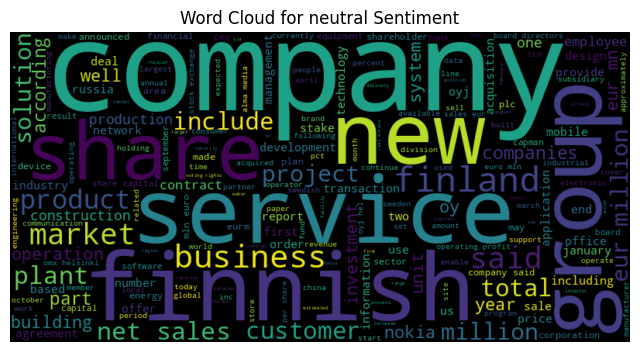

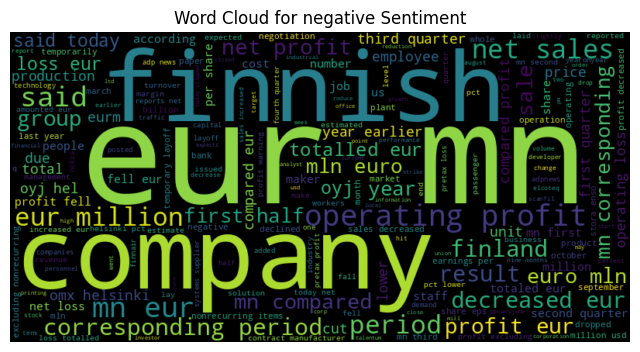

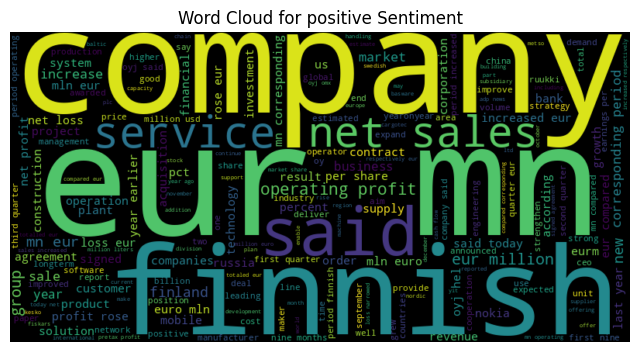

In [11]:
# Create a word cloud for each sentiment category
sentiment_categories = df['label'].unique()
for sentiment in sentiment_categories:
    text_for_sentiment = " ".join(df[df['label'] == sentiment]['clean_text'])
    wordcloud = WordCloud(width=800, height=400).generate(text_for_sentiment)
    plt.figure(figsize=(8, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f'Word Cloud for {sentiment} Sentiment')
    plt.axis("off")
    plt.show()

## 5. Logistic Regression

### 5.1 TF-IDF Vectorization and Train/Test Split

In [12]:
# Split the data into features (X) and labels (y)
X = df["clean_text"]
y = df["label"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a TF-IDF vectorizer and transform the text data
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = tfidf_vectorizer.transform(X_test).toarray()

### 5.2 Building and Trainig the Model

In [13]:
# Create a logistic regression model
logistic_regression = LogisticRegression(C=1.5)

# Train the model on the training data
logistic_regression.fit(X_train_tfidf, y_train)

LogisticRegression(C=1.5)

### 5.3 Evaluating the Model

Accuracy: 0.76

Classification Report:
              precision    recall  f1-score   support

    negative       0.81      0.44      0.57       118
     neutral       0.74      0.96      0.84       563
    positive       0.81      0.50      0.62       287

    accuracy                           0.76       968
   macro avg       0.79      0.63      0.67       968
weighted avg       0.77      0.76      0.74       968


Confusion Matrix:


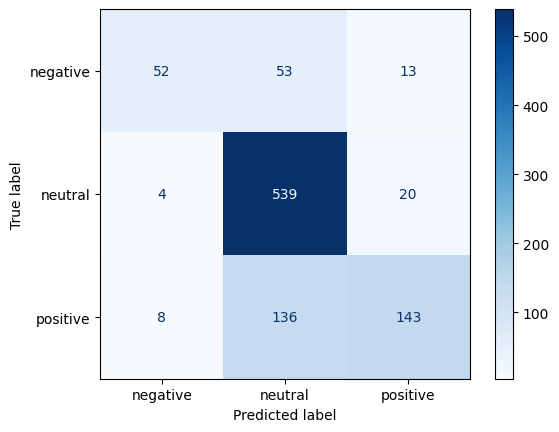

In [14]:
# Get prediction
y_pred = logistic_regression.predict(X_test_tfidf)

# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['negative', 'neutral', 'positive'])
disp.plot(cmap='Blues')
plt.grid(False)
plt.show()

## 6. Explainig the Model using SHAP (SHapley Additive exPlanations)
SHAP (SHapley Additive exPlanations) is a tool in machine learning that explains the output of any machine learning model. It's based on Shapley values from cooperative game theory and offers the following features:

1. **Model Agnostic**: Works with any machine learning model.
2. **Local and Global Explanations**: Provides detailed explanations for individual predictions and overall model behavior.
3. **Feature Importance**: Shows how much each feature in the dataset contributes to a prediction.
4. **Intuitive and Fair**: The explanations are easy to understand and consistently represent the impact of each feature.

Essentially, SHAP helps in understanding why a model makes certain predictions, making machine learning models more transparent and interpretable.

In [15]:
# Setup SHAP Explainer
explainer = shap.Explainer(
    logistic_regression, X_train_tfidf, feature_names=tfidf_vectorizer.get_feature_names_out()
)
shap_values = explainer(X_test_tfidf)

### 6.1 Visualize the Impact of Features for Each Label

In [16]:
shap_values.shape

(968, 8361, 3)

In [17]:
logistic_regression.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

Negative


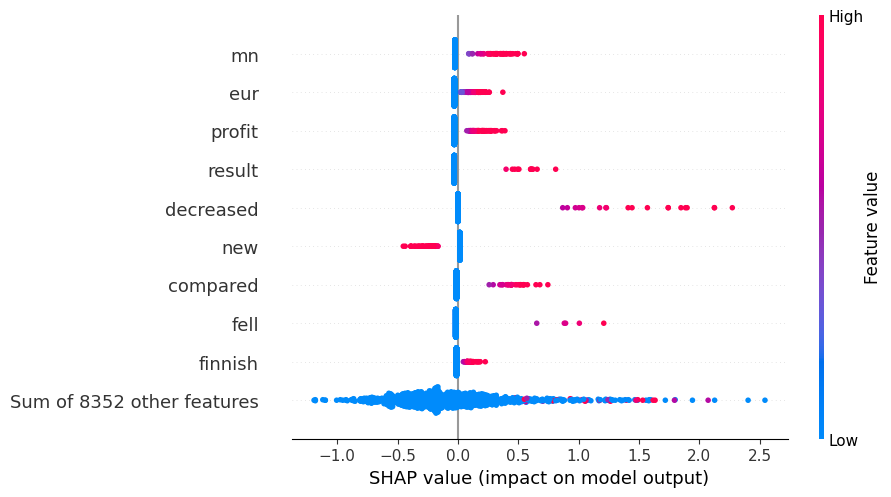

In [18]:
print("Negative")
shap.plots.beeswarm(shap_values[:, :, 0])

Neutral


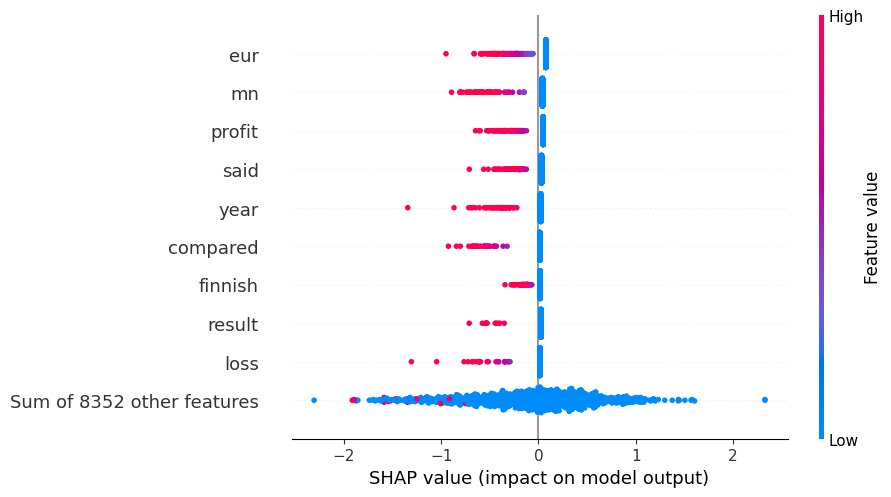

In [19]:
print("Neutral")
shap.plots.beeswarm(shap_values[:, :, 1])

Positive


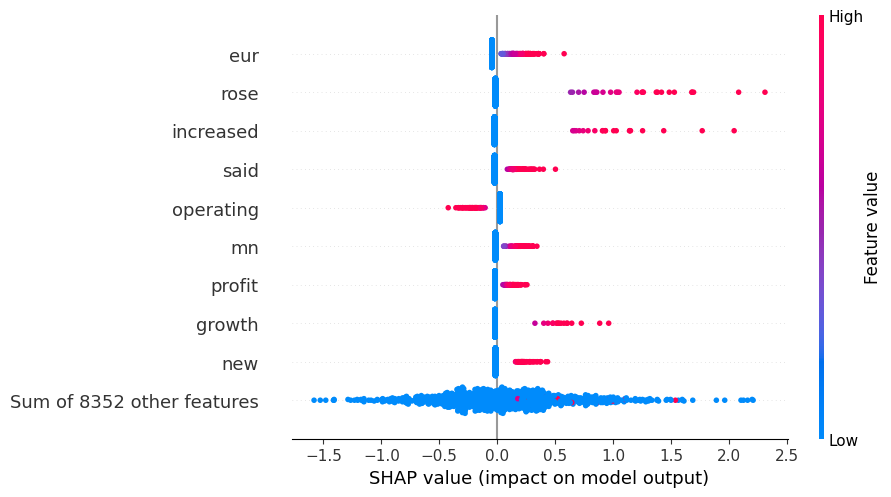

In [20]:
print("Positive")
shap.plots.beeswarm(shap_values[:, :, 2])

Higher shap values mean higher impact on the model output. As expected, negative terms, such as "decreased" and "fell", have stronger impacts on negative output, and positive terms like "increased" and "rose" have strong positive impacts on positive output label.

### 6.2 Explain predicion
Randomly sample a news title from the test dataset and visualize the prediction.

In [21]:
# Reset index for the test dataset
X_test_reset = X_test.reset_index() # Keep the original index to get original text
X_test_reset.columns = ['original_index', 'clean_text'] # Rename columns for clarity
y_test_reset = y_test.reset_index(drop=True)

In [22]:
import random

def explain_single_predicion(shap_values, label):
    """
    Select a random sample from the test dataset and explain the prediction

    :param shap_values: shap values
    :param label: label to select (negative, neutral, positive)
    :return: None
    """
    filtered_y_test = y_test_reset[y_test_reset==label]
    if not filtered_y_test.empty:
        # Randomly select a sample from the test dataset
        random_sample = filtered_y_test.sample()
        random_idx = random_sample.index.to_numpy()
        random_true_label = random_sample.values[0]
        pred_label = y_pred[random_idx][0]

        # Print out the true label and predicted label
        print(f"True Label: {random_true_label} | Predicted Label: {pred_label}")
        
        # Print out the original text
        original_idx = X_test_reset.loc[random_idx]["original_index"].values
        text = df.loc[original_idx]["text"].values[0]
        print(f"\nNews Title: {text}")
        print("-----------------------------------------------------------")
        
        # Explain features impacting each label
        print("\nNegative")
        shap.plots.force(shap_values[random_idx, :, 0], matplotlib=True)
        print("\nNeutral")
        shap.plots.force(shap_values[random_idx, :, 1], matplotlib=True)
        print("\nPositive")
        shap.plots.force(shap_values[random_idx, :, 2], matplotlib=True)

True Label: negative | Predicted Label: negative

News Title: In sales volume , Coca-Cola 's market share has decreased by 2.2 % to 24.2 % .
-----------------------------------------------------------

Negative


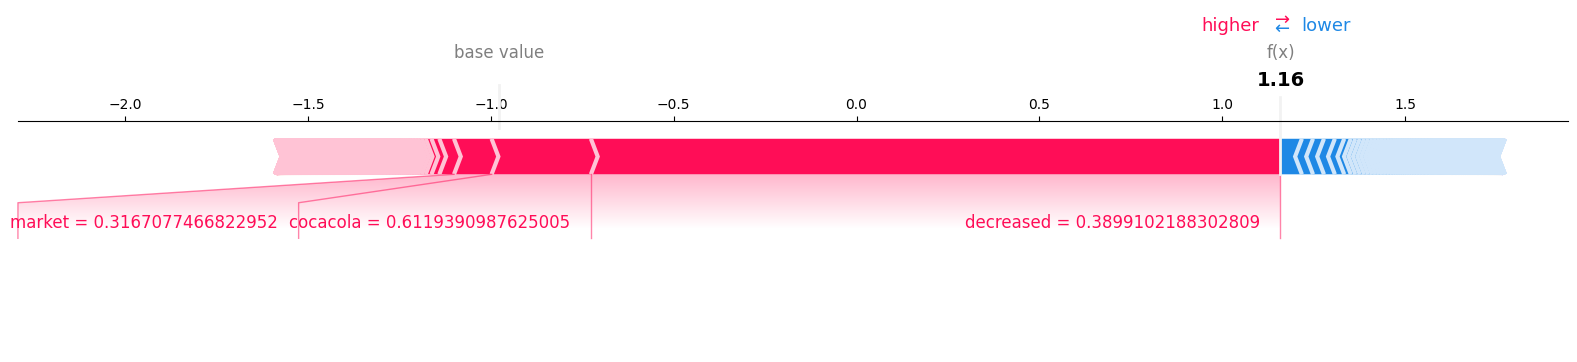


Neutral


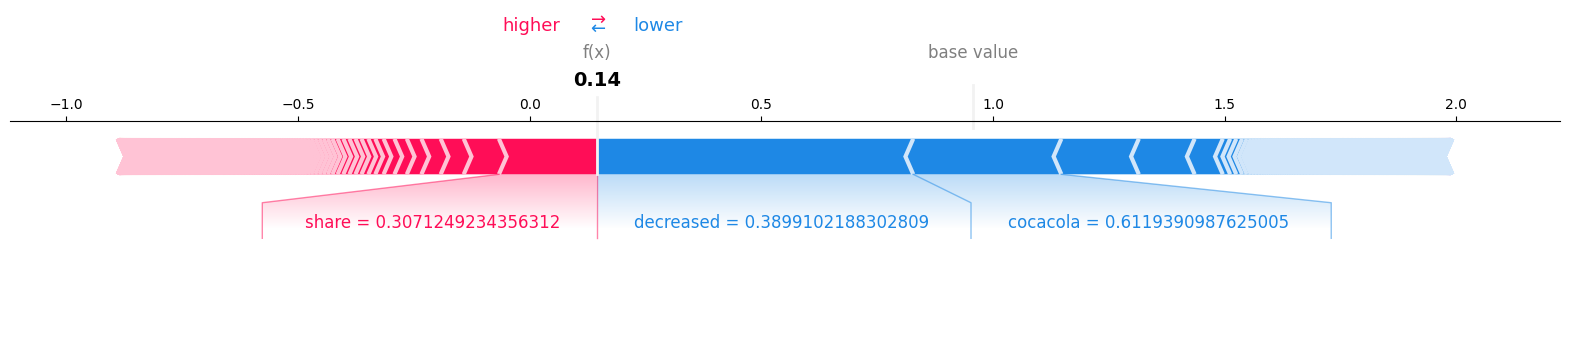


Positive


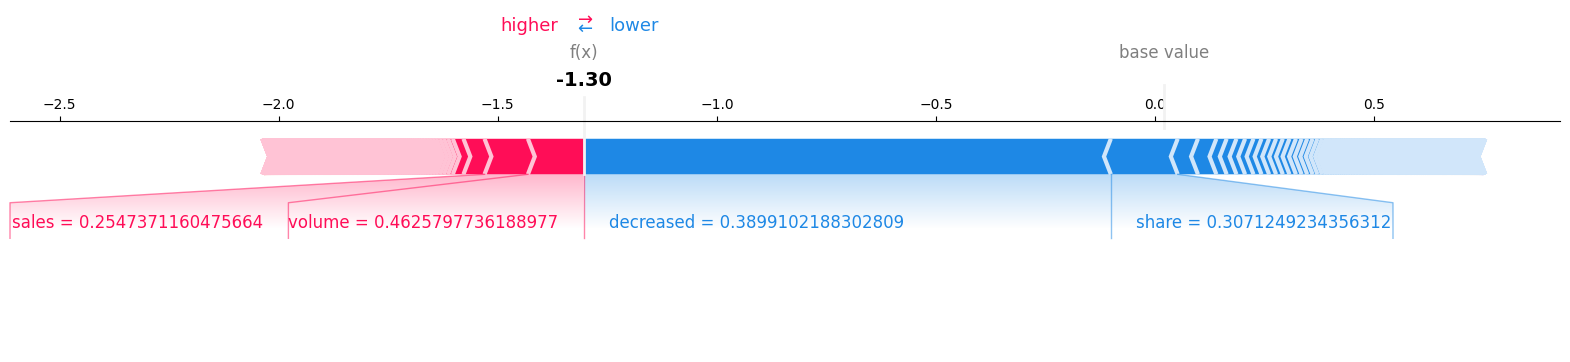

In [25]:
explain_single_predicion(shap_values, "negative")

True Label: positive | Predicted Label: positive

News Title: Demand seems to have hit bottom now , and some signs of improvement can be seen .
-----------------------------------------------------------

Negative


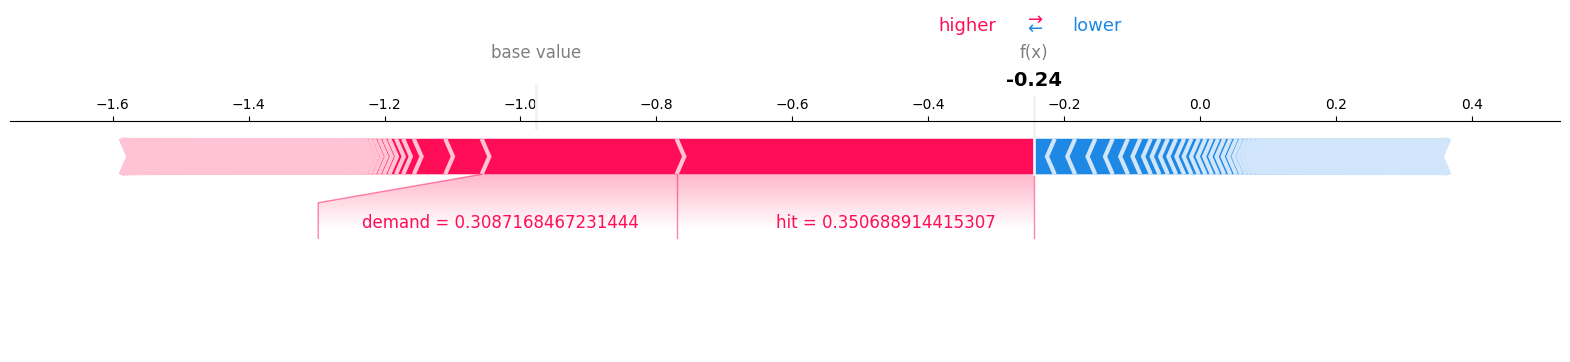


Neutral


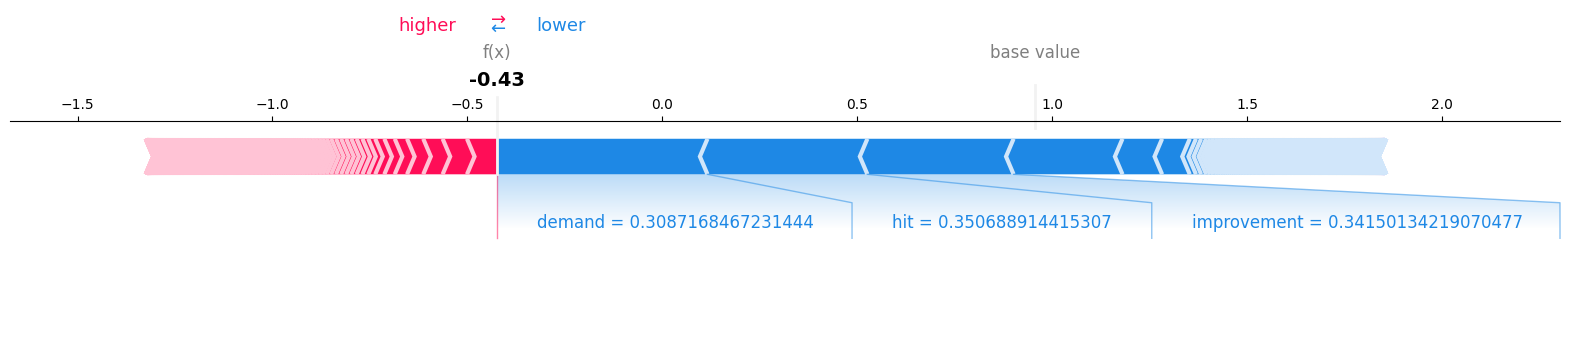


Positive


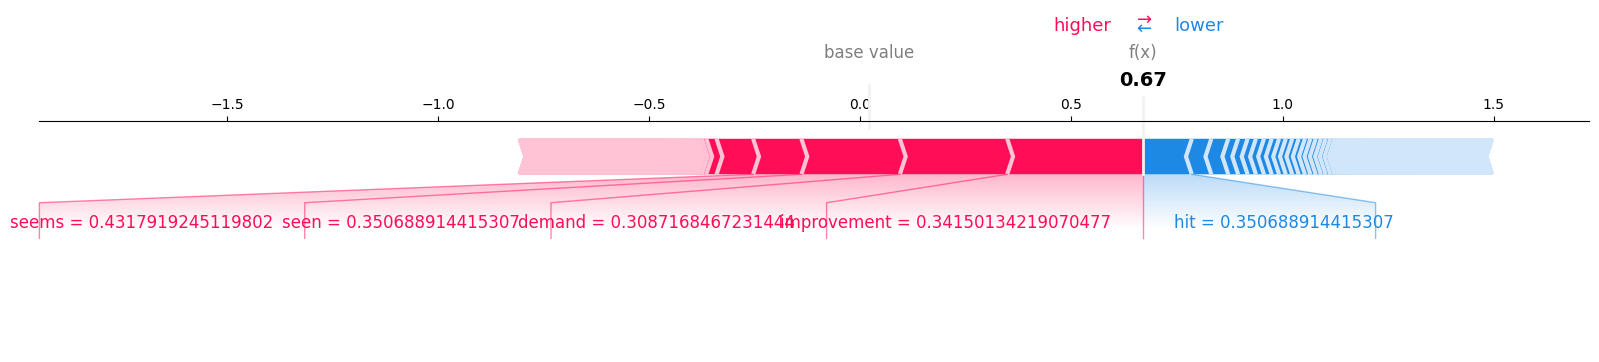

In [30]:
explain_single_predicion(shap_values, "positive")

True Label: neutral | Predicted Label: neutral

News Title: As a condition to the deal , Savcor Alfa has to have bought Photonium and Akseli Lahtinen Inc. 's business operations prior to the deal .
-----------------------------------------------------------

Negative


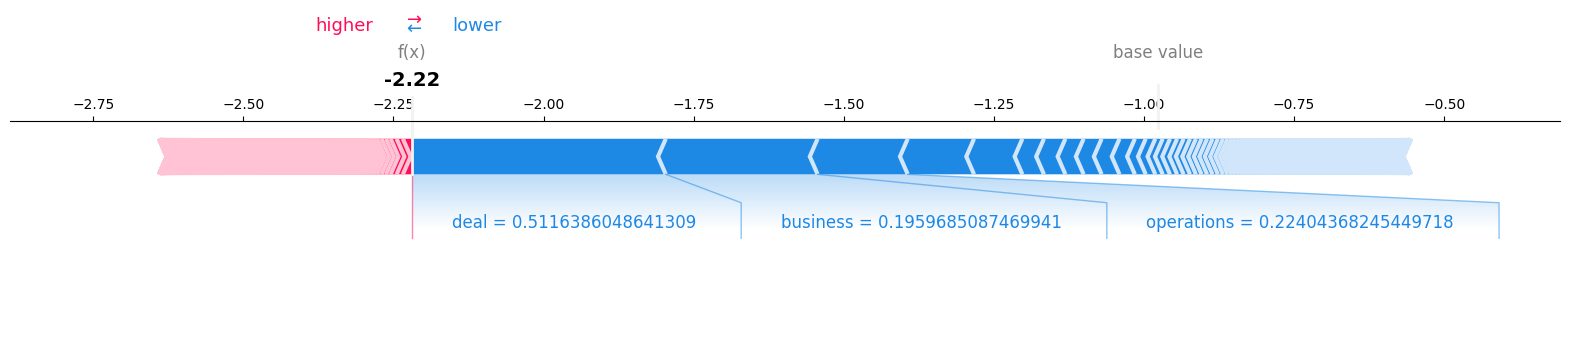


Neutral


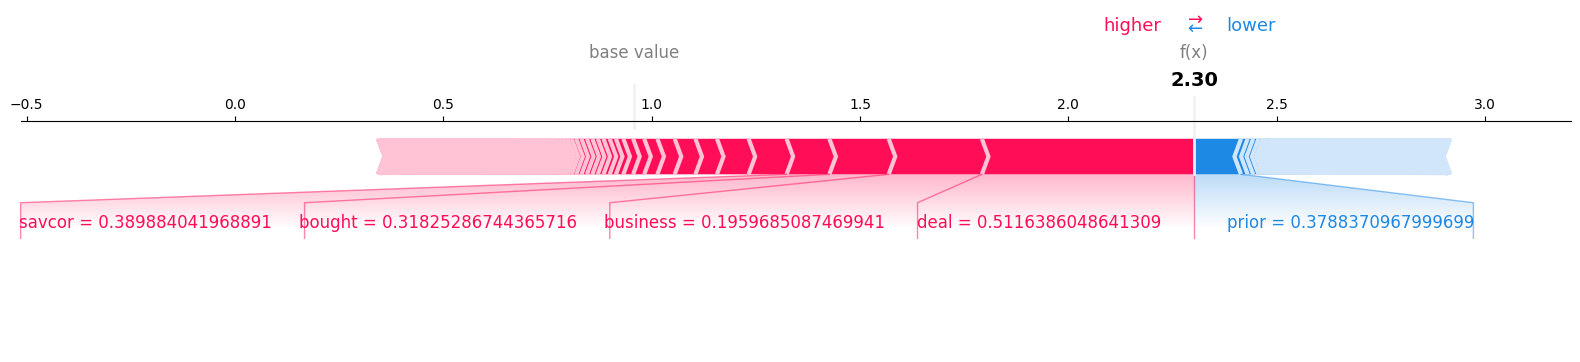


Positive


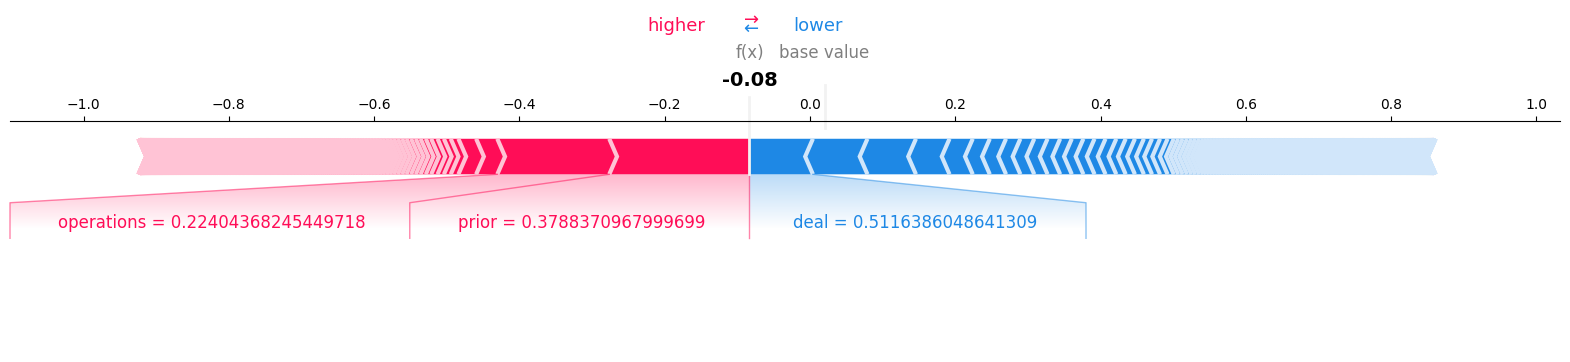

In [31]:
explain_single_predicion(shap_values, "neutral")